## Load Open AI API Key

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
import os
import yaml

with open("openai_key.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)

os.environ["OPENAI_API_KEY"] = api_creds['openai_key']

## Load Tavily Search API Key

In [4]:
import os
import yaml

with open("tavily_key.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)

os.environ["TAVILY_API_KEY"] = api_creds['tavily_key']

## Build Collaborative Multi-Agent System

## Create Tools

In [5]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tv_search = TavilySearchResults(max_results=5, search_depth='advanced',
                                max_tokens=10000)

repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to generate the chart."],):
    """Use this to execute python code.
       If you want to see the output of a value,
       you should print it out with `print(...)`.

       This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")

### Graph State

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Create Agents

We will create two main agents here:

1. The Researcher Agent which can access the web search tool to make web searches to get information on user queries
2. The Chart Agent which can use python to create data visualizations

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

llm = ChatOpenAI(model="gpt-4o", temperature=0)

search_tool = [tv_search]
search_tool_name = tv_search.name
research_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {search_tool_name}

                          You should provide accurate data for use
                          and source code shouldn't be the final answer
                       """,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

research_agent = (research_prompt
                      |
                  llm.bind_tools(search_tool))


chart_tool = [python_repl]
chart_tool_name = python_repl.name
chart_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                          Use the provided tools to progress towards answering the question.
                          If you are unable to fully answer, that's OK,
                          another assistant with different tools will help where you left off.
                          Execute what you can to make progress.
                          If you or any of the other assistants have the final answer or deliverable,
                          prefix your response with FINAL ANSWER so the team knows to stop.

                          You have access to the following tools:
                          {chart_tool_name}

                          Run the python code to display the chart
                       """,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

chart_agent = (chart_prompt
                  |
               llm.bind_tools(chart_tool))

### Define Agent Nodes

In [8]:
from langchain_core.messages import ToolMessage, AIMessage

def research_agent_node(state):
    result = research_agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="Researcher")
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "Researcher",
    }


def chart_agent_node(state):
    result = chart_agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name="chart_generator")
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": "chart_generator",
    }


### Define Tool Node

In [9]:
from langgraph.prebuilt import ToolNode

tools = [tv_search, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic

In [10]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

### Define the Multi-Agent Graph

In [11]:
from langgraph.graph import END, StateGraph

agent = StateGraph(AgentState)

agent.add_node("Researcher", research_agent_node)
agent.add_node("chart_generator", chart_agent_node)
agent.add_node("call_tool", tool_node)

agent.add_conditional_edges(
    "Researcher",
    router,
    # routing map
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
agent.add_conditional_edges(
    "chart_generator",
    router,
    # routing map
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

agent.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    # routing map
    {"Researcher": "Researcher", "chart_generator": "chart_generator"},
)

agent.set_entry_point("Researcher")
agent = agent.compile()

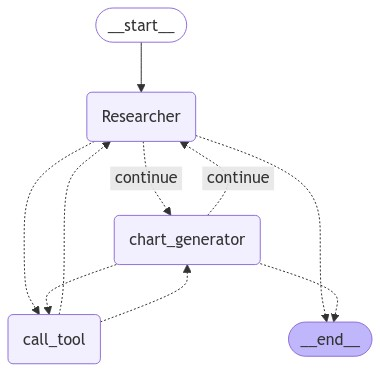

In [12]:
from IPython.display import Image, display, Markdown

display(Image(agent.get_graph().draw_mermaid_png()))

## Test the Multi-Agent System

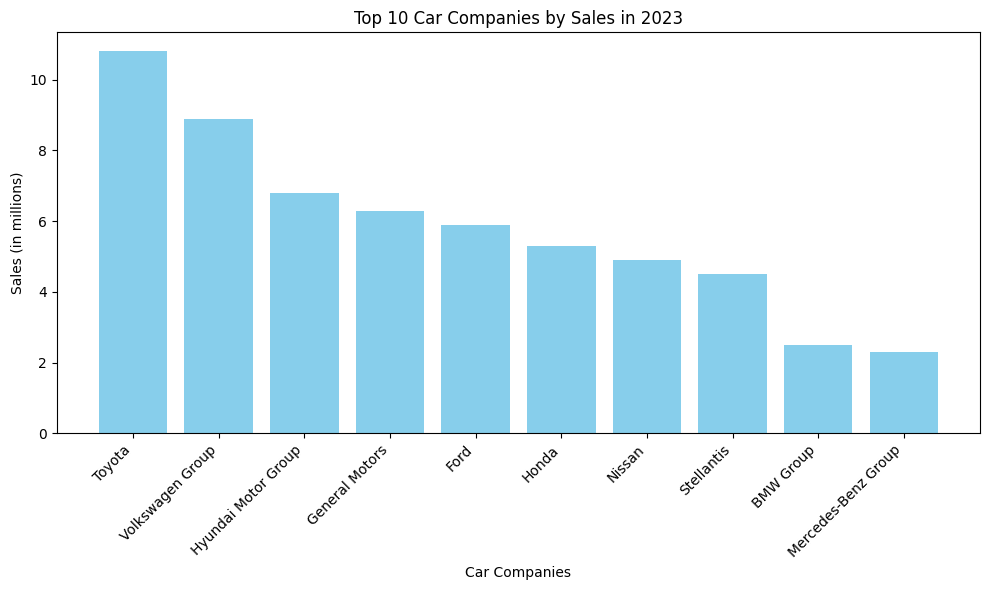

In [16]:
prompt = """Fetch the data of the top 10 car companies with the highest sales in the world.
            Then use this data and draw a bar chart.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)

In [17]:
response

{'messages': [('human',
   'Fetch the data of the top 10 car companies with the highest sales in the world.\n            Then use this data and draw a bar chart.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ENHGFJLZHFm39prRVvA9wkBm', 'function': {'arguments': '{"query":"top 10 car companies by sales 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 236, 'total_tokens': 263, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a20a4ee344', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-88fe2ffb-2540-4e04-829d-6479b527ba6e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 10 car companies by sales 2023'}, 'id': 'call_ENHGFJLZHF

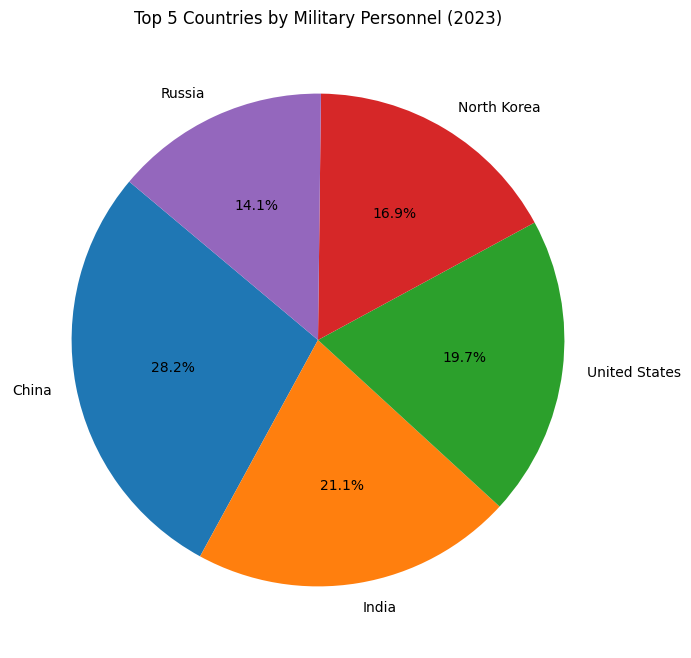

In [20]:
prompt = """Fetch the data of top 5 highest military personnal from all over the world.
            Then use this data and draw a pie chart in percentage.
         """

response = agent.invoke({"messages": [('human', prompt)]},
                        # Maximum number of steps to take in the graph
                        {"recursion_limit": 150},)

In [21]:
response

{'messages': [('human',
   'Fetch the data of top 5 highest military personnal from all over the world.\n            Then use this data and draw a pie chart in percentage.\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Qz1uckQJEuQQeQ4AOJJJv6Md', 'function': {'arguments': '{"query":"top 5 countries by number of military personnel 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 236, 'total_tokens': 265, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a20a4ee344', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-90a3df53-217e-4d24-9450-e0a2f72f421c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'top 5 countries by number of mil